## Using Machine Learning to determine the drivers of housing prices during a prosperous (increasing) housing market (2010 market boom)
Book # 5

- Explore the dataset
- Train, test & holdout
- Perform Regression models
- Extract information for coefficients

**Goal : Identify what are the Sale Price drivers during a booming market**

Note: full address was kept within the dataset for prediction, but was removed from the coef list since it gave too much noise for coef interpretation. 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'input/'

Mounted at /content/gdrive


In [ ]:
# packages to import

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_importance,XGBClassifier,XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import r2_score

from scipy.stats import skew

In [ ]:
file_path = '/content/gdrive/My Drive/resale-flat-prices/'
print(file_path)

/content/gdrive/My Drive/resale-flat-prices/


In [ ]:
# importing dataframes

df_high = pd.read_csv(file_path + 'df_high_p4.csv')


###**Central Area Housing Prices & Drivers During an Economic BOOM**

In [ ]:
# Central Area 

df_central = df_high[df_high['region'] == 'Central']

Skew is:  0.6138844159490582


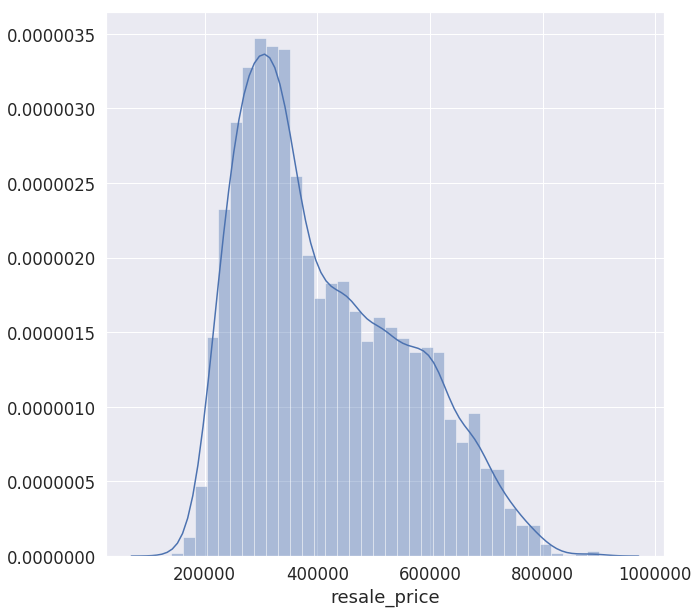

In [ ]:
# Target 
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.distplot(df_central['resale_price'])
print('Skew is: ',skew(df_central['resale_price']))

**The housing prices are very skewed , try per square feet**

Skew is:  0.6168548581589364


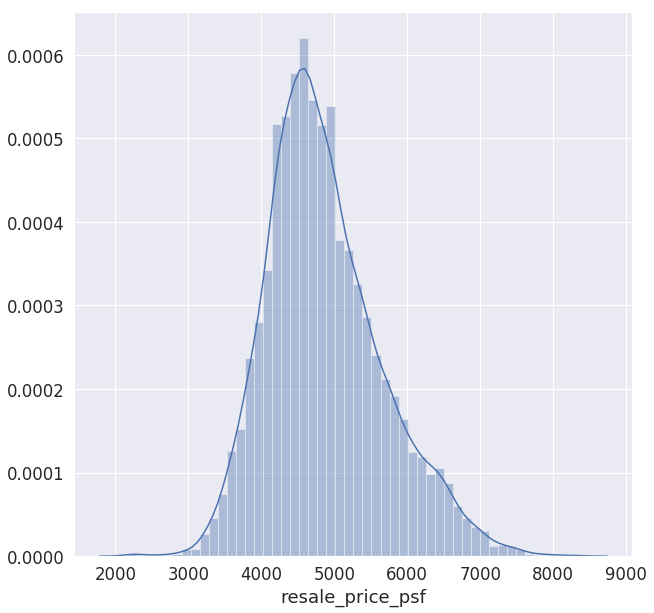

In [ ]:
# Target : Resale Price per sqaure foot 
sns.distplot(df_central['resale_price_psf'])
print('Skew is: ',skew(df_central['resale_price_psf']))

**Housing prices are still skewed, but look normally distributed. Proceed with analysis**

In [ ]:
cat_features = ['town', 'flat_type', 'storey_range', 'flat_model',
                'full_address', 'nearest_mrt','nearest_school']
       
num_features = ['lease_commence_date', 'remaining_lease', 'max_floor_lvl','total_dwelling_units' ,'1room_sold', '2room_sold','3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
        'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental','other_room_rental', 'Latitude', 'Longitude',
       'nearest_distance','nearest_distance_school', 'Ranking', 'Tot_Vacancy','perc_balance_vacancy', 'Month']

dum_features = ['residential','commercial', 'market_hawker', 'miscellaneous', 'multistorey_carpark',
       'precinct_pavilion', 'is_interchange']



# Transforming the data into a new proper dataframe
def creating_dataframe(df):

  
  # Get dummified values
  dummies = pd.get_dummies(df[cat_features], drop_first = True)
  print('Added Columns from Dummies :', dummies.shape[1])
  dummies.reset_index(drop = True, inplace = True)
  
  #Dummies Dataframe
  df.reset_index(drop = True, inplace = True)
  dummies = pd.concat([dummies, df[dum_features]], axis = 1)
  
  # Standard Scaling 
  std = StandardScaler()
  num_std = pd.DataFrame(std.fit_transform(df[num_features]))
  num_std.columns = num_features
  num_std.reset_index(drop = True, inplace = True)
  
  X = pd.concat([num_std, dummies], axis = 1)
  print('Total Number of Columns :', X.shape[1])
  print('Total Number of Rows :', X.shape[0])
  
  df = pd.concat([df[['resale_price_psf']],X], axis = 1)
  
  return df



  
# To get the scaler only 
def std_scaler(df):
  num_features = ['lease_commence_date', 'remaining_lease', 'max_floor_lvl','total_dwelling_units' ,'1room_sold', '2room_sold','3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
        'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental','other_room_rental', 'Latitude', 'Longitude',
       'nearest_distance','nearest_distance_school', 'Ranking', 'Tot_Vacancy','perc_balance_vacancy', 'Month']
  
  # Standard Scaling 
  std = StandardScaler()
  std = std.fit(df[num_features])
  
  return std
  

In [ ]:
new_central_df = creating_dataframe(df_central)

Added Columns from Dummies : 1595
Total Number of Columns : 1626
Total Number of Rows : 9024


In [ ]:
# Define y (target) as the resale price per square foot
X = new_central_df.drop(columns = ['resale_price_psf'])
y = new_central_df['resale_price_psf']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.84853572 0.83165469 0.84362826]
0.8412728923635185
0.1


In [ ]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.8374539614934432


**Extract coefficients to see dolar values**
Note: coefficients need to be transformed using the standard scaler to derive the monetary value.

In [ ]:
std = std_scaler(df_central)

In [ ]:
def coef_dataframe(X):
  conversion_of_coef_list =[tuple(ridge.coef_)]
  coefs = pd.DataFrame(conversion_of_coef_list, columns = X.columns, index = ['Dollar Value ($)'])

  # Reversing the Standardardization of the numerical stardardized values
  # Standard Scaling 
  coefs[num_features] = std.transform(coefs[num_features])
  
  # new DataFrame with the coefficients 
  dollar_values = pd.DataFrame(X.columns, columns = ['Driver'])
  dollar_values['Dollar Value per Sqft'] = coefs.values.tolist()[0]
  dollar_values = dollar_values[~dollar_values.Driver.str.contains("full_address")]
  
  return dollar_values

In [ ]:
dollar_values_central = coef_dataframe(X)

In [ ]:
print('Top 20 Positive Drivers in 2010 in the Central Area')
dollar_values_central.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(10)

Top 20 Positive Drivers in 2010 in the Central Area


Driver  Dollar Value per Sqft
52                                   flat_model_terrace            2602.174967
41                                   storey_range_40-50             946.811764
29                                   town_MARINE PARADE             897.570366
1551       nearest_mrt_BRAS BASAH MRT STATION SINGAPORE             848.782012
25                                     town_BUKIT TIMAH             811.283200
40                                   storey_range_30-40             800.283919
1                                       remaining_lease             630.479369
1554      nearest_mrt_BUONA VISTA MRT STATION SINGAPORE             486.664897
39                                   storey_range_20-30             483.564113
1605            nearest_school_ Nanyang Primary School              472.730125
0                                   lease_commence_date             472.043678
1607           nearest_school_ Ngee Ann Primary School              455.179584
1617                    nearest_school_ Tao Nan School              442.390782
1565         nearest_mrt_LAVENDER MRT STATION SINGAPORE             435.318885
50                                flat_model_simplified             342.575351
51                                  flat_model_standard             340.025844
1609  nearest_school_ Pei Hwa Presbyterian Primary S...             338.553075
1592        nearest_school_ Farrer Park Primary School              331.185019
1585         nearest_school_ Cantonment Primary School              320.439102
1600                nearest_school_ Kheng Cheng School              310.753114

In [ ]:
print('Top 20 Negative Drivers in 2010 in the Central Area')
dollar_values_central.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(20)

Top 20 Negative Drivers in 2010 in the Central Area


Driver  Dollar Value per Sqft
16                                             Latitude           -9309.973179
17                                            Longitude           -3790.402589
1603                 nearest_school_ Maha Bodhi School             -774.687799
18                                     nearest_distance            -584.939802
1595  nearest_school_ Geylang Methodist School (Prim...            -559.616151
1584   nearest_school_ Canossa Catholic Primary School             -547.895466
28                                 town_KALLANG/WHAMPOA            -465.021161
1587              nearest_school_ Cedar Primary School             -403.749422
1566     nearest_mrt_LITTLE INDIA MRT STATION SINGAPORE            -387.072812
1621                                      market_hawker            -356.970852
1591  nearest_school_ Fairfield Methodist School (Pr...            -338.025693
1547          nearest_mrt_BARTLEY MRT STATION SINGAPORE            -334.279716
1611          nearest_school_ Radin Mas Primary School             -287.142432
24                                     town_BUKIT MERAH            -277.584303
1588                    nearest_school_ Chij (Kellock)             -263.462500
1598         nearest_school_ Henry Park Primary School             -253.493294
1570   nearest_mrt_NICOLL HIGHWAY MRT STATION SINGAPORE            -249.157816
1613        nearest_school_ St. Andrew’s Junior School             -245.362535
1606           nearest_school_ New Town Primary School             -242.411882
1575       nearest_mrt_QUEENSTOWN MRT STATION SINGAPORE            -240.679835

###**Major Positive Driver of Prices in the Central Area During an Economic Boom**

No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text xticklabel objects>)

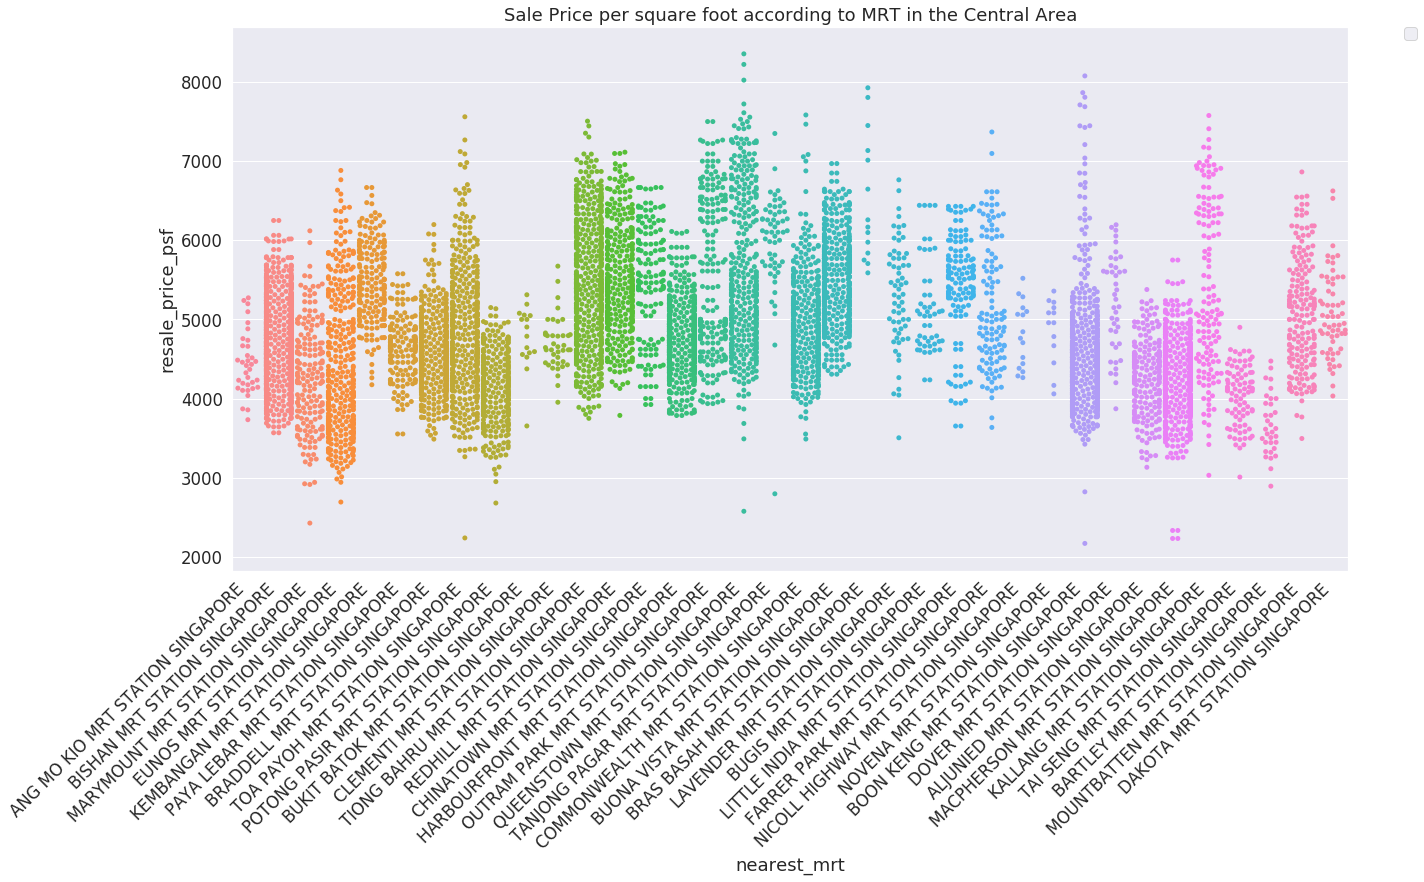

In [ ]:
sns.set(rc={'figure.figsize':(20,10)},  font_scale=1.5)
sns.swarmplot(x = 'nearest_mrt', y = 'resale_price_psf', data = df_central)
plt.title('Sale Price per square foot according to MRT in the Central Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45, ha='right')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

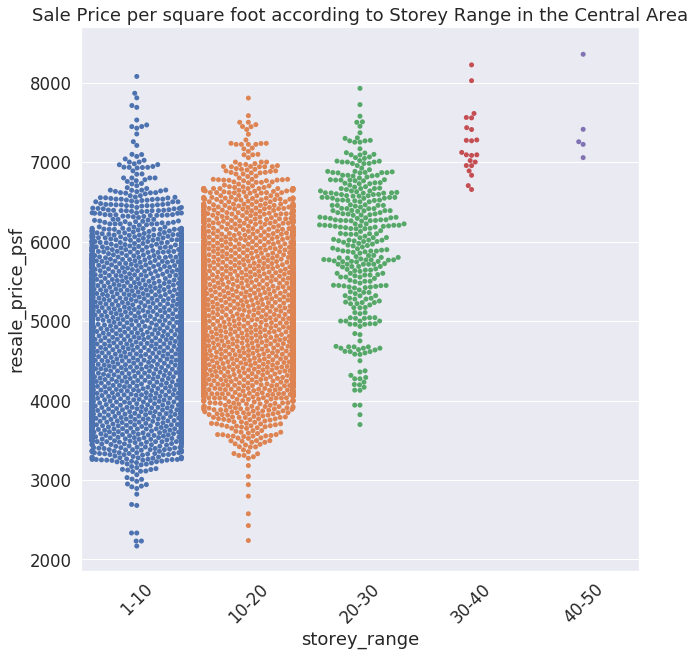

In [ ]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.swarmplot(x = 'storey_range', y = 'resale_price_psf', data = df_central)
plt.title('Sale Price per square foot according to Storey Range in the Central Area')
plt.xticks(rotation = 45, ha='center')

###**Eastern Area Housing Prices & Drivers During an Economic BOOM**

In [ ]:
# Eastern Area of Singapore 

df_east = df_high[df_high['region'] == 'East']

Skew is:  0.5605705573774891


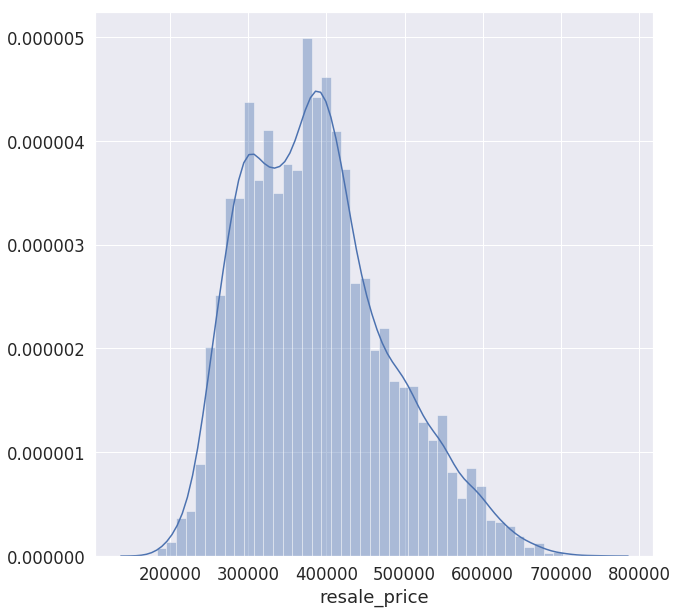

In [ ]:
# Target 
sns.distplot(df_east['resale_price'])
print('Skew is: ',skew(df_east['resale_price']))

**Highly distributed Sale Prices, not good**

Skew is:  0.3326743932583071


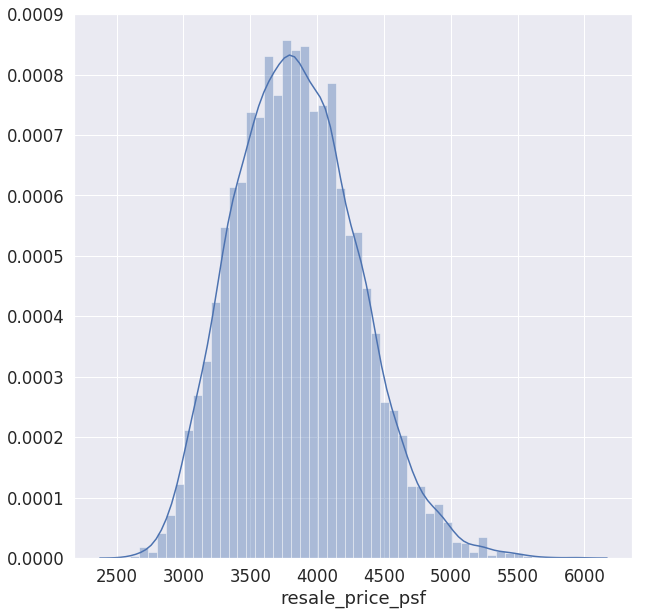

In [ ]:
# Target : Resale Price per sqaure foot 
sns.distplot(df_east['resale_price_psf'])
print('Skew is: ',skew(df_east['resale_price_psf']))

**Good distribution & Small skew, no need for log transform**

In [ ]:
new_eastern_df = creating_dataframe(df_east)

Added Columns from Dummies : 1523
Total Number of Columns : 1554
Total Number of Rows : 7712


In [ ]:
# Define y (target) as the resale price per square foot
X = new_eastern_df.drop(columns = ['resale_price_psf'])
y = new_eastern_df['resale_price_psf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.76848053 0.78820312 0.80053106]
0.7857382356764578
1.0


In [ ]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.7892298322653842


In [ ]:
std = std_scaler(df_east)
dollar_values_eastern = coef_dataframe(X)

In [ ]:
print('Top 20 Positive Drivers in 2010 in the Eastern Area')
dollar_values_eastern.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers in 2010 in the Eastern Area


Driver  Dollar Value per Sqft
32                                  storey_range_20-30             468.972451
1                                      remaining_lease             384.797884
1512  nearest_mrt_CHANGI AIRPORT MRT STATION SINGAPORE             371.604337
1526             nearest_school_ Eunos Primary School              349.493865
44                                 flat_model_standard             323.553636
1543           nearest_school_ Temasek Primary School              219.447811
1521          nearest_school_ Changkat Primary School              174.723677
31                                  storey_range_10-20             168.556007
1541          nearest_school_ Tampines Primary School              152.901795
1519       nearest_school_ Bedok Green Primary School              121.386345
33                            flat_model_adjoined flat             111.241865
19                             nearest_distance_school             110.427286
43                               flat_model_simplified             109.410552
1546             nearest_school_ Yumin Primary School               96.789237
0                                  lease_commence_date              96.741208
1527          nearest_school_ Fengshan Primary School               81.667428
1536              nearest_school_ Red Swastika School               79.522862
1525        nearest_school_ Elias Park Primary School               76.078689
42                       flat_model_premium maisonette              63.063285
38                       flat_model_model a-maisonette              48.945806

In [ ]:
print('Top 10 Negative Drivers in 2010 in the Eastern Area')
dollar_values_eastern.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 10 Negative Drivers in 2010 in the Eastern Area


Driver  Dollar Value per Sqft
17                                  Longitude           -7657.441926
16                                   Latitude           -2024.344933
28                           flat_type_5 ROOM           -1097.876558
29                        flat_type_EXECUTIVE            -928.951993
27                           flat_type_4 ROOM            -830.214743
26                           flat_type_3 ROOM            -459.076494
18                           nearest_distance            -391.567962
36                      flat_model_maisonette            -243.553598
1516  nearest_mrt_SIMEI MRT STATION SINGAPORE            -239.973102
37                         flat_model_model a            -221.173380

###**Major Negative Driver of Prices in the Eastern Area During an Economic BOOM**

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

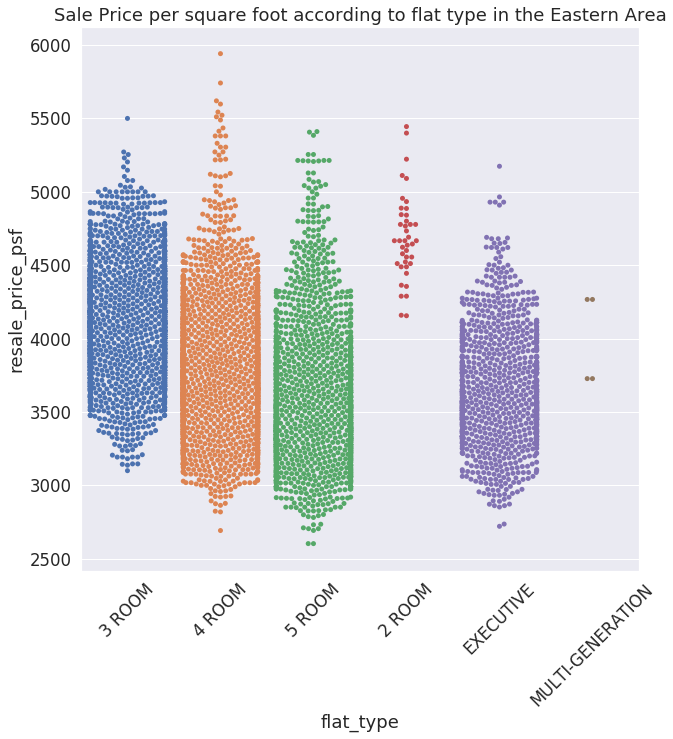

In [ ]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.swarmplot(x = 'flat_type', y = 'resale_price_psf', data = df_east)
plt.title('Sale Price per square foot according to flat type in the Eastern Area')
plt.xticks(rotation = 45)

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <a list of 10 Text xticklabel objects>)

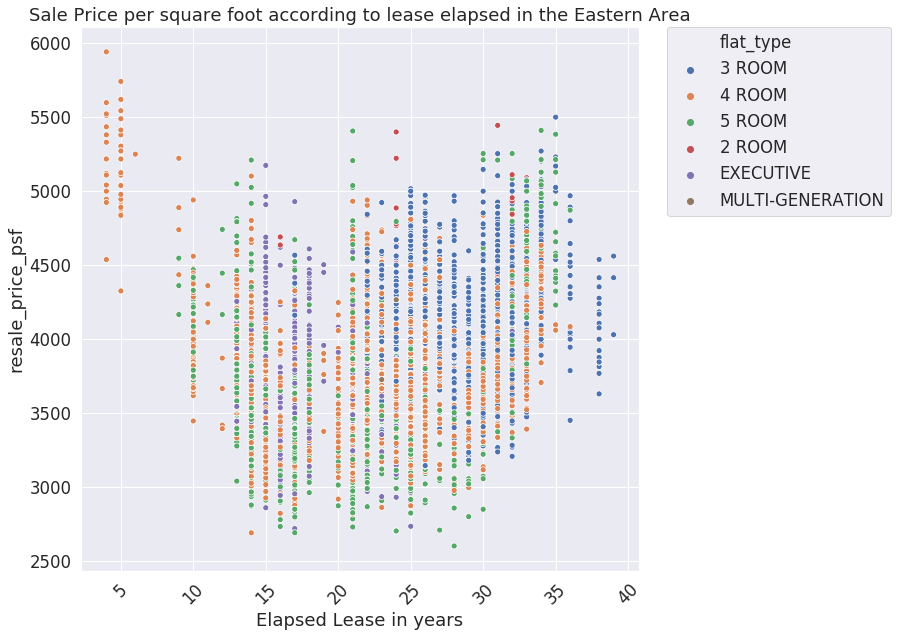

In [ ]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.scatterplot(x = 'remaining_lease', y = 'resale_price_psf', data = df_east, hue = 'flat_type')
plt.title('Sale Price per square foot according to lease elapsed in the Eastern Area')
plt.xlabel('Elapsed Lease in years')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45)

###**Western Area Housing Prices & Drivers During an Economic BOOM**

In [ ]:
# Western area of Singapore
df_west = df_high[df_high['region'] == 'West']

Skew is:  0.6947504076535966


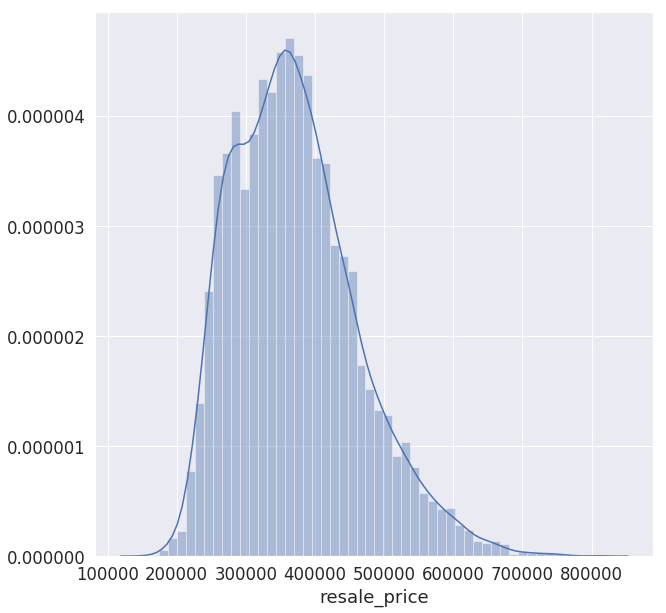

In [ ]:
# Target 
sns.distplot(df_west['resale_price'])
print('Skew is: ',skew(df_west['resale_price']))

**The distribution of prices is skewed**

Skew is:  0.6793908789415566


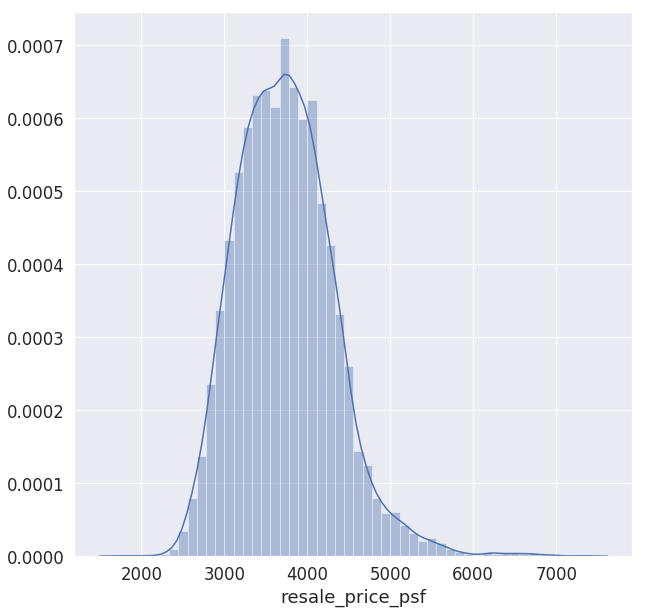

In [ ]:
# Target 
sns.distplot(df_west['resale_price_psf'])
print('Skew is: ',skew(df_west['resale_price_psf']))

**The distribution of prices is normal, but slightly skewed.**

In [ ]:
new_west_df = creating_dataframe(df_west)

Added Columns from Dummies : 2027
Total Number of Columns : 2058
Total Number of Rows : 9894


In [ ]:
# Define y (target) as the resale price per square foot
X = new_west_df.drop(columns = ['resale_price_psf'])
y = new_west_df['resale_price_psf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.85951812 0.85765076 0.86091582]
0.8593615647347749
0.1


In [ ]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.8727693674590897


In [ ]:
std = std_scaler(df_west)
dollar_values_west = coef_dataframe(X)

In [ ]:
print('Top 20 Positive Drivers in 2010 in the Western Area')
dollar_values_west.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers in 2010 in the Western Area


Driver  Dollar Value per Sqft
17                                        Longitude            9128.499232
1                                   remaining_lease             492.273902
2033       nearest_school_ Pei Tong Primary School              379.349808
34                               storey_range_20-30             376.627963
28                                 town_JURONG WEST             303.239331
2032        nearest_school_ Nan Hua Primary School              293.016195
0                               lease_commence_date             289.481537
29                                 flat_type_3 ROOM             288.541533
24                               town_BUKIT PANJANG             277.778322
2022       nearest_school_ Frontier Primary School              196.171542
2007     nearest_mrt_CLEMENTI MRT STATION SINGAPORE             187.433643
26                                    town_CLEMENTI             181.878647
33                               storey_range_10-20             177.645798
2047        nearest_school_ Xingnan Primary School              133.026783
2050       nearest_school_ Zhenghua Primary School              129.210556
2027         nearest_school_ Juying Primary School              121.837712
2014  nearest_school_ Bukit Panjang Primary School              121.570981
2017       nearest_school_ Clementi Primary School              119.929183
44                            flat_model_simplified             115.080586
27                                 town_JURONG EAST             112.196734

In [ ]:
print('Top 10 Negative Drivers in 2010 in the Western Area')
dollar_values_west.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 10 Negative Drivers in 2010 in the Western Area


Driver  Dollar Value per Sqft
16                                           Latitude            -860.589720
18                                   nearest_distance            -487.525758
43                      flat_model_premium maisonette            -358.591331
31                                   flat_type_5 ROOM            -298.016191
2038           nearest_school_ Shuqun Primary School             -261.335091
2030         nearest_school_ Lakeside Primary School             -258.623230
2029           nearest_school_ Kranji Primary School             -233.465132
2021              nearest_school_ De La Salle School             -219.733484
2006  nearest_mrt_CHOA CHU KANG MRT STATION SINGAPORE            -218.543269
2012        nearest_mrt_YEW TEE MRT STATION SINGAPORE            -216.526403

###**Major Negative Driver of Prices in the West Area During an Economic BOOM**

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

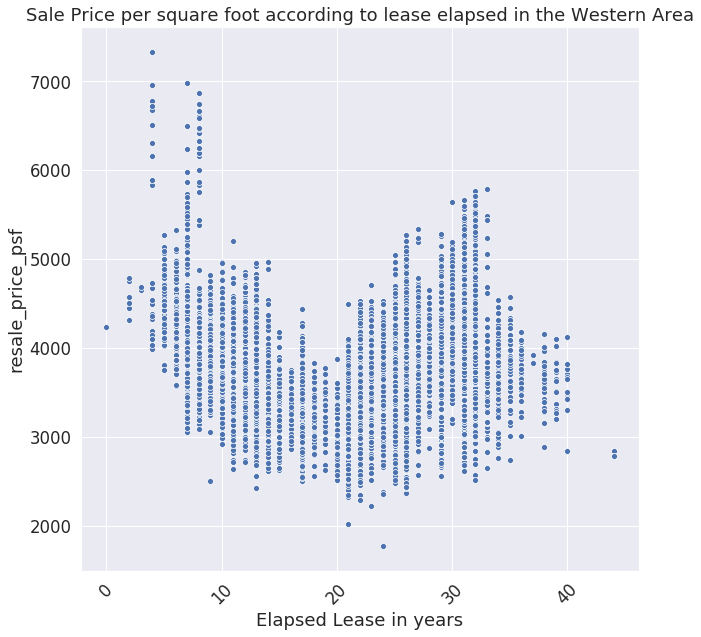

In [ ]:

sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.scatterplot(x = 'remaining_lease', y = 'resale_price_psf', data = df_west)
plt.title('Sale Price per square foot according to lease elapsed in the Western Area')
plt.xlabel('Elapsed Lease in years')
plt.xticks(rotation = 45)

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <a list of 10 Text xticklabel objects>)

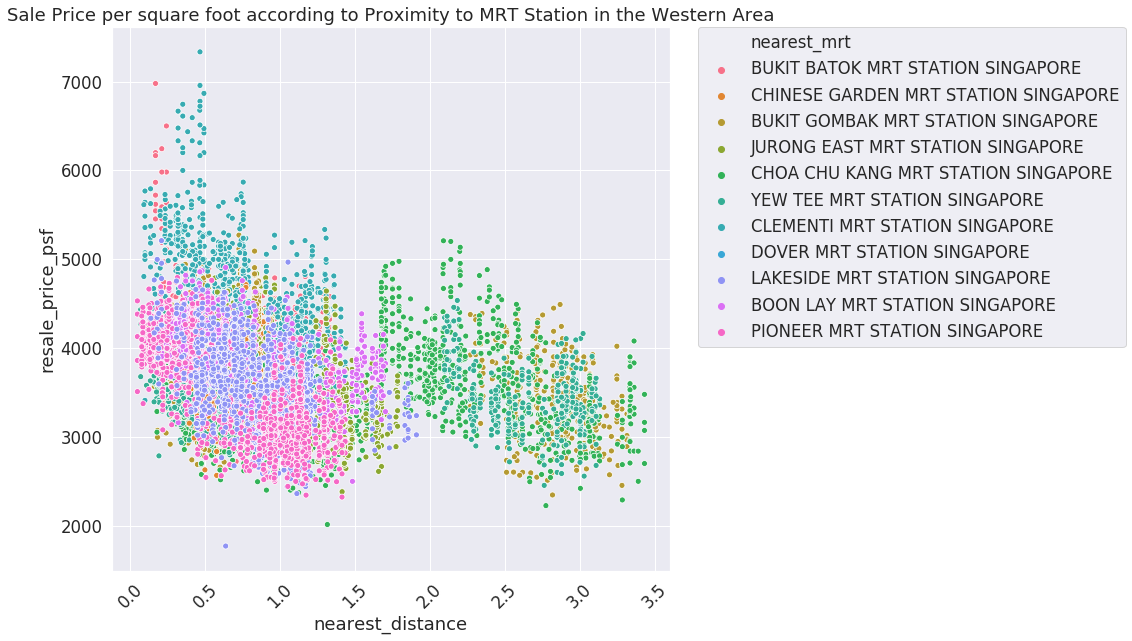

In [ ]:

sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.scatterplot(x = 'nearest_distance', y = 'resale_price_psf', data = df_west, hue = 'nearest_mrt')
plt.title('Sale Price per square foot according to Proximity to MRT Station in the Western Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45)

###**Northern Area Housing Prices & Drivers During an Economic BOOM**

In [ ]:
# Northern area of Singapore
df_north = df_high[df_high['region'] == 'North']

Skew is:  0.5695402361617443


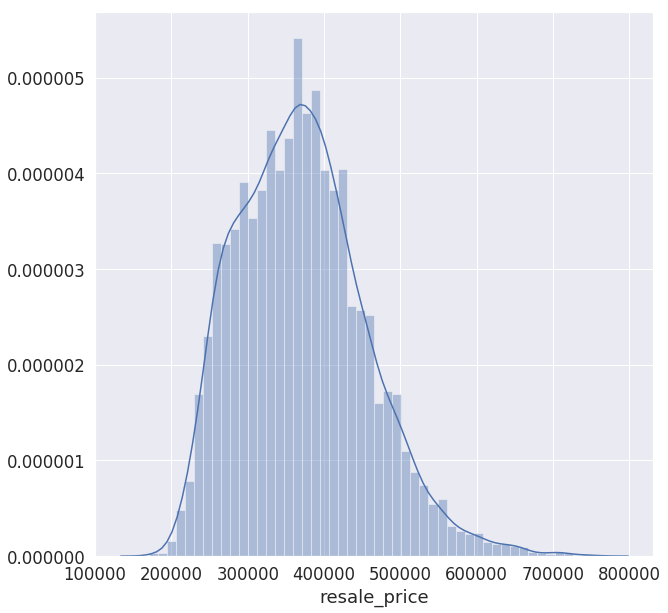

In [ ]:
# Target 
sns.distplot(df_north['resale_price'])
print('Skew is: ',skew(df_north['resale_price']))

**The data is a bit awkard. Not fully normal**

Skew is:  0.6245143315871765


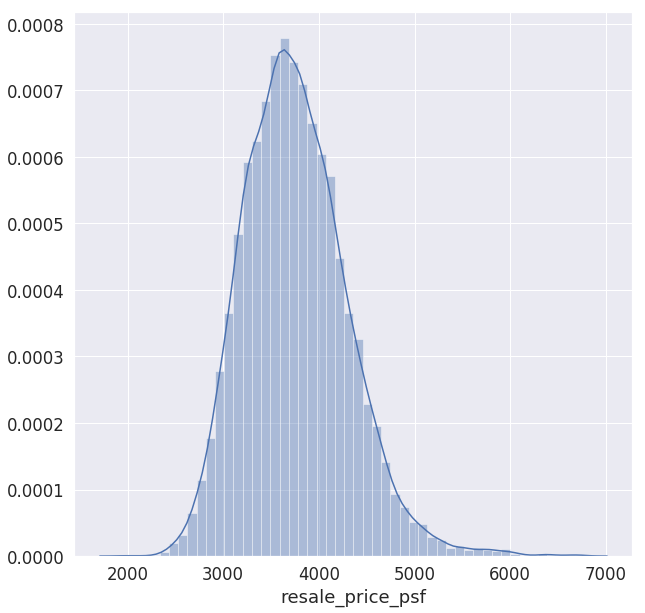

In [ ]:
# Target 
sns.distplot(df_north['resale_price_psf'])
print('Skew is: ',skew(df_north['resale_price_psf']))

**Correcting for the square footage makes the data much better**

In [ ]:
new_north_df = creating_dataframe(df_north)

Added Columns from Dummies : 2847
Total Number of Columns : 2878
Total Number of Rows : 14243


In [ ]:
# Define y (target) as the resale price per square foot
X = new_north_df.drop(columns = ['resale_price_psf'])
y = new_north_df['resale_price_psf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.83226968 0.83411661 0.82873642]
0.8317075679580376
1.0


In [ ]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.849750002473064


In [ ]:
std = std_scaler(df_north)
dollar_values_northern = coef_dataframe(X)

In [ ]:
print('Top 20 Positive Drivers in 2010 in the Northen Area')
dollar_values_northern.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers in 2010 in the Northen Area


Driver  Dollar Value per Sqft
2792      nearest_mrt_ANG MO KIO MRT STATION SINGAPORE             437.127792
1                                      remaining_lease             410.571909
37                                  storey_range_20-30             409.139565
40                      flat_model_improved-maisonette             340.560009
2809          nearest_school_ Anderson Primary School              299.438357
2860        nearest_school_ Wellington Primary School              218.075896
2859          nearest_school_ Waterway Primary School              213.404566
0                                  lease_commence_date             211.136969
25                                        town_PUNGGOL             207.096209
2870          nearest_school_ Zhonghua Primary School              199.474867
2867         nearest_school_ Yangzheng Primary School              190.938131
2869            nearest_school_ Yishun Primary School              190.375976
2822         nearest_school_ Greendale Primary School              185.233103
36                                  storey_range_10-20             160.114494
28                                      town_SERANGOON             155.500178
2833         nearest_school_ Mayflower Primary School              147.287401
2825           nearest_school_ Horizon Primary School              146.163180
2811  nearest_school_ CHIJ St. Nicholas Girls’ School              144.653009
2826           nearest_school_ Hougang Primary School              135.848195
2828            nearest_school_ Innova Primary School              127.928322

In [ ]:
print('Top 10 Negative Drivers in 2010 in the Northern Area')
dollar_values_northern.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 10 Negative Drivers in 2010 in the Northern Area


Driver  Dollar Value per Sqft
17                                    Longitude           -5965.935468
16                                     Latitude           -4835.950598
34                          flat_type_EXECUTIVE            -729.558622
33                             flat_type_5 ROOM            -725.368829
29                               town_WOODLANDS            -559.177728
32                             flat_type_4 ROOM            -464.106538
18                             nearest_distance            -424.048908
42                           flat_model_model a            -330.706844
15                            other_room_rental            -328.020411
2854  nearest_school_ Seng Kang Primary School             -258.302467

###**Major Positive Driver of Prices in the Northern Area During an Economic BOOM**

**Similar to the other regions, the flat type and model are major contributors to housing prices.**

**What has yet to be looked at is how the newest flats were more expensive per sqft. Therefore, newer flats (i.e those who just came into the market) were more expensive and most likely modern.**

- Although the trend is observed accross, one of the main reason why this may be the case is that bigger glats were being built in the later years and thus they became more expensive. 
- We can see that the 1992 flat prices are much higher. This could be due to the newer BTO flats being released on the market.

No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 <a list of 65 Text xticklabel objects>)

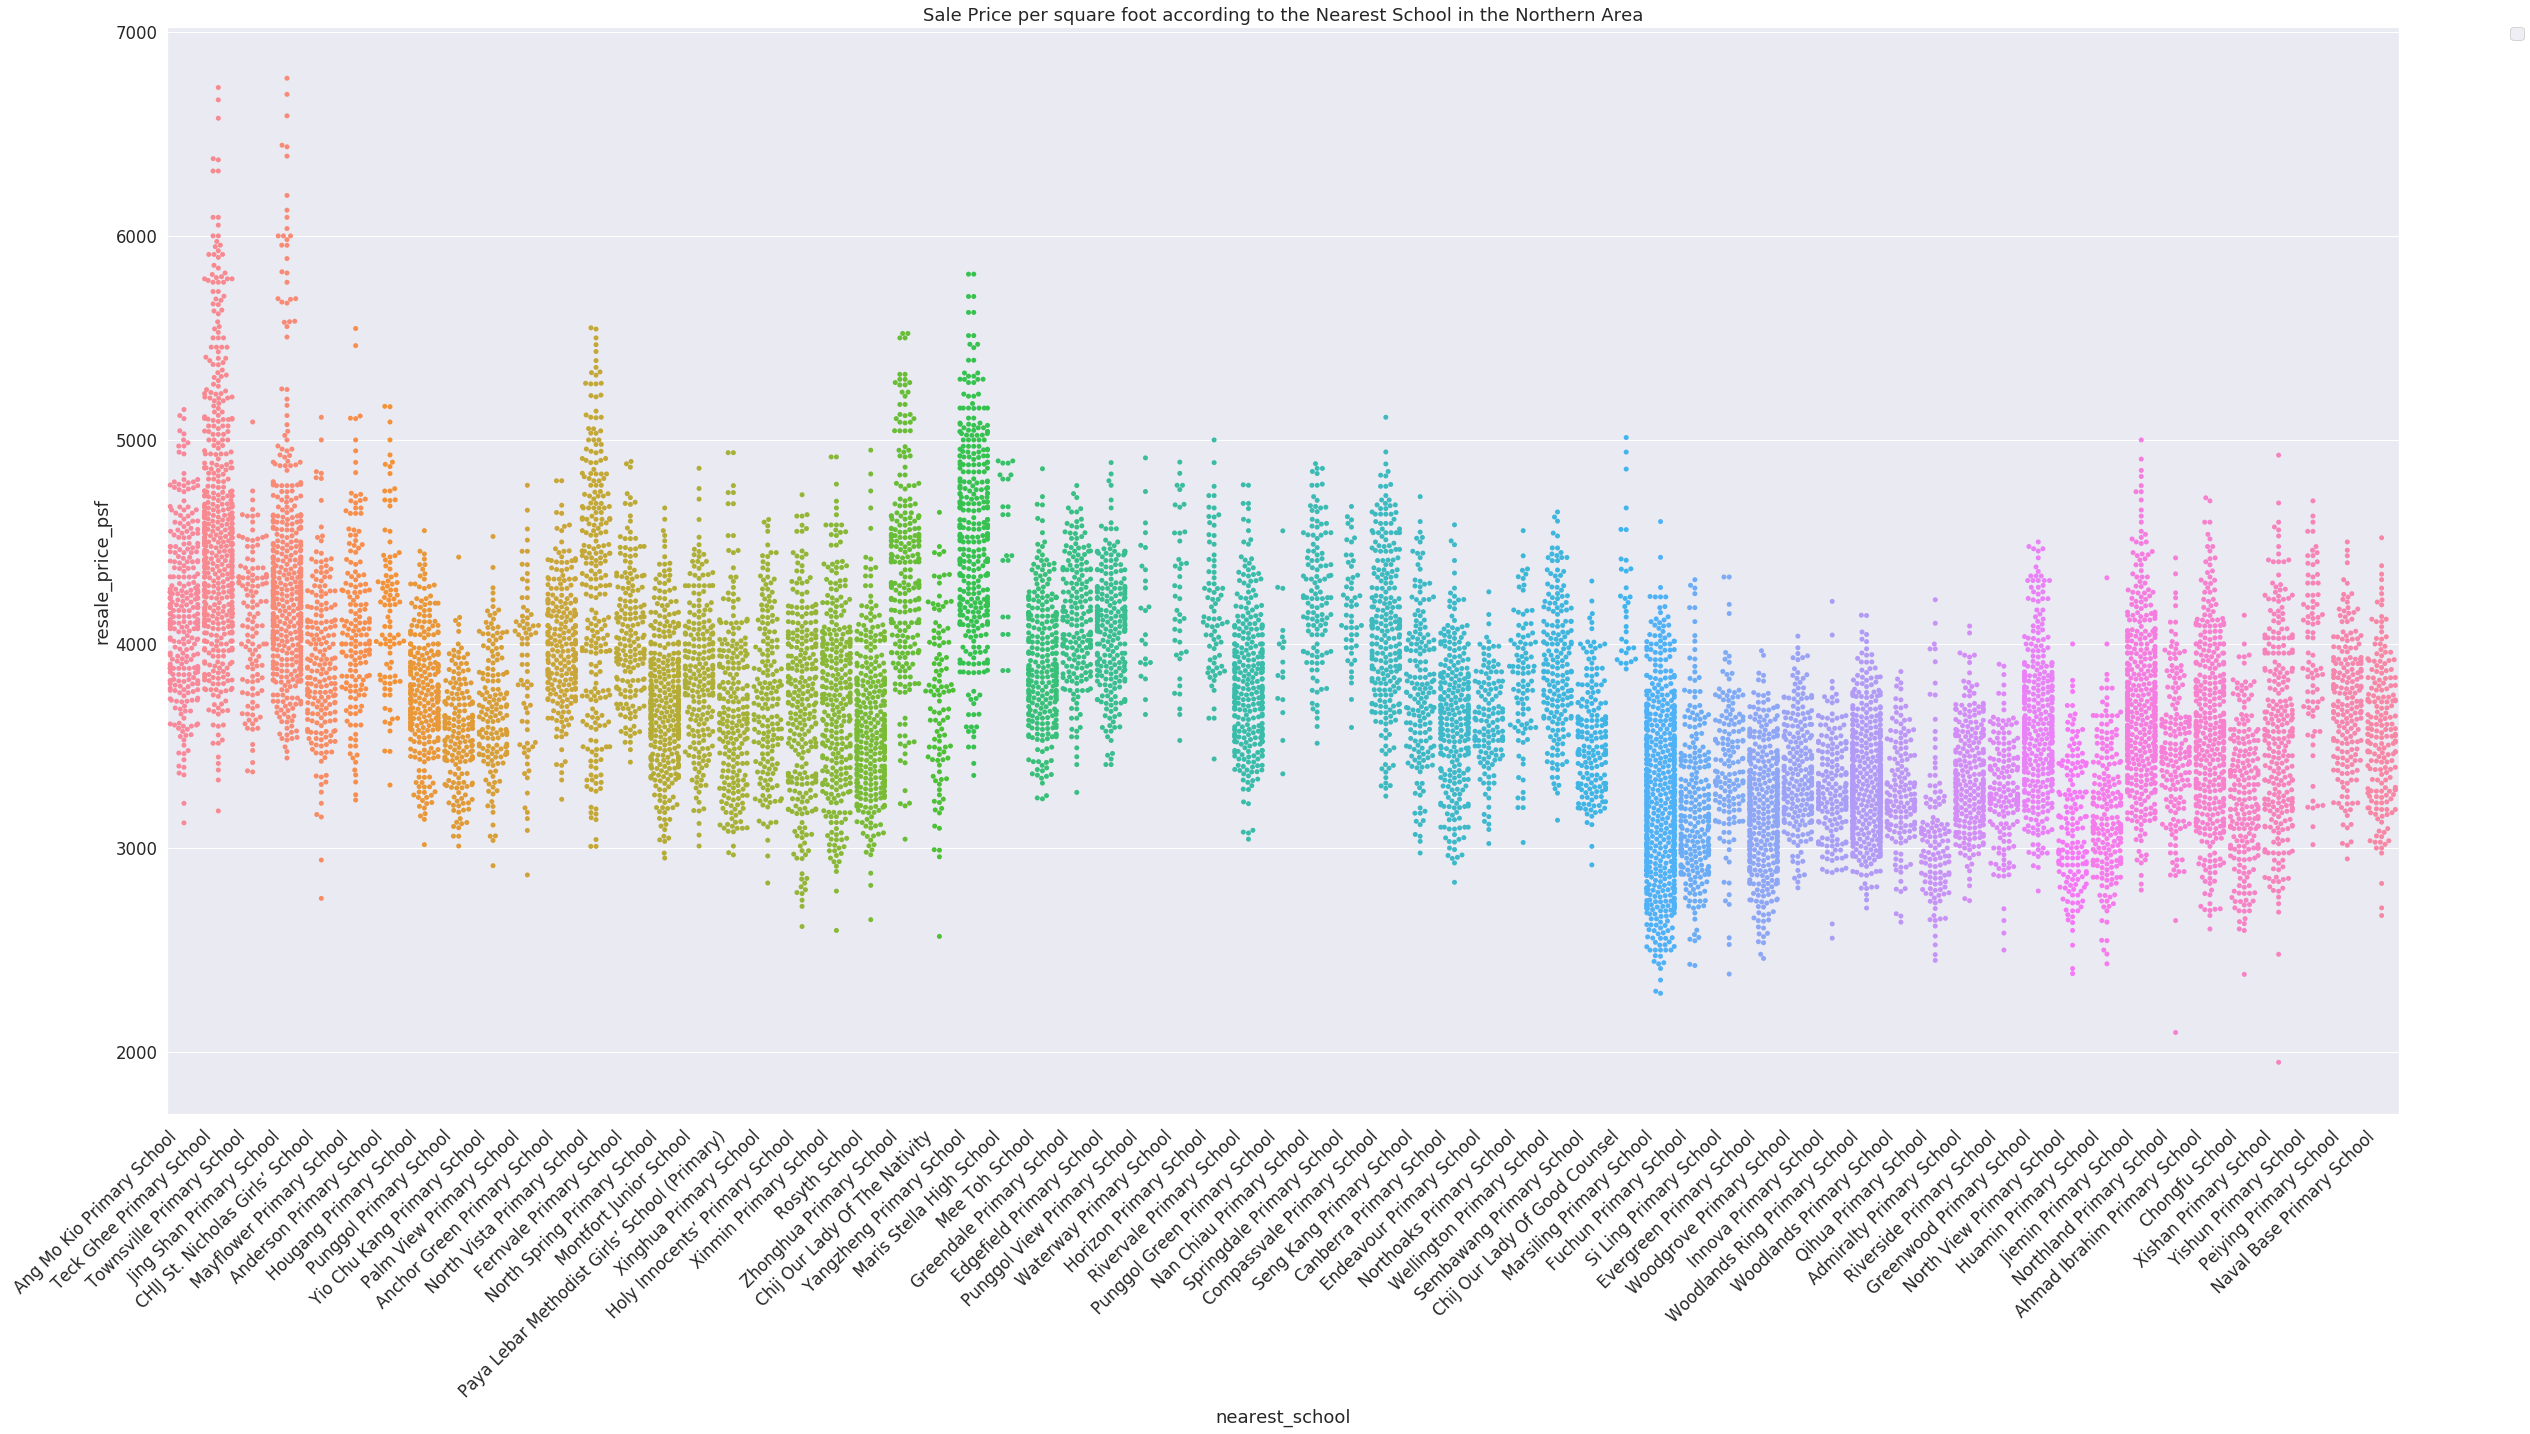

In [ ]:
sns.set(rc={'figure.figsize':(40,20)},  font_scale=1.5)
sns.swarmplot(x = 'nearest_school', y = 'resale_price_psf', data = df_north)
plt.title('Sale Price per square foot according to the Nearest School in the Northern Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45, ha='right')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

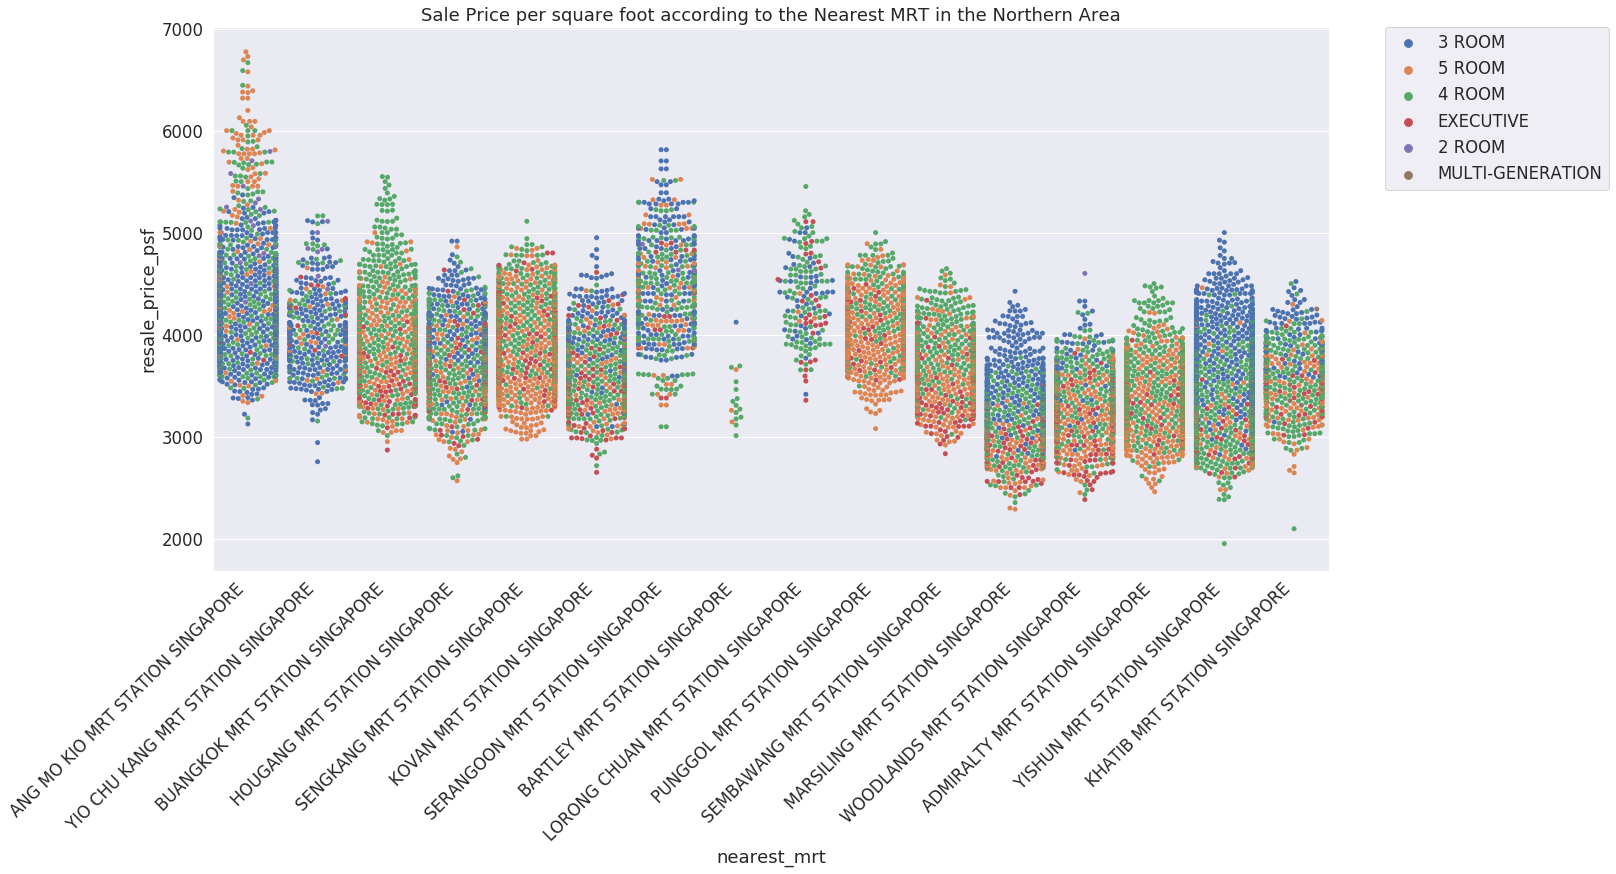

In [ ]:
sns.set(rc={'figure.figsize':(20,10)},  font_scale=1.5)
sns.swarmplot(x = 'nearest_mrt', y = 'resale_price_psf', data = df_north, hue = 'flat_type')
plt.title('Sale Price per square foot according to the Nearest MRT in the Northern Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45, ha='right')

###**Conclusion**

**Drivers of the Property Market in an economic BOOM**

**NEW AND CONVENIENT**

- Closeness to new MRT stations
- Newly released HDB flats
- Closeness to Schools

In [ ]:
print('Mean Home Price in the Central Area: ', int(df_central['resale_price'].mean()), '// Price Per Sqft:',int(df_central['resale_price_psf'].mean()))
print('Mean Home Price in the Eastern Area: ', int(df_east['resale_price'].mean()), '// Price Per Sqft:',int(df_east['resale_price_psf'].mean()))
print('Mean Home Price in the Western Area: ', int(df_west['resale_price'].mean()), '// Price Per Sqft:',int(df_west['resale_price_psf'].mean()))
print('Mean Home Price in the Northern Area: ', int(df_north['resale_price'].mean()), '// Price Per Sqft:',int(df_north['resale_price_psf'].mean()))


Mean Home Price in the Central Area:  411921 // Price Per Sqft: 4866
Mean Home Price in the Eastern Area:  386920 // Price Per Sqft: 3847
Mean Home Price in the Western Area:  371281 // Price Per Sqft: 3730
Mean Home Price in the Northern Area:  370476 // Price Per Sqft: 3754
